# Определение перспективного тарифа для телеком компании

В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
Нам представлены файлы в формате *.csv*: файл с данными о пользователях, файл со звонками пользователей, файл с отправленными сообщениями и файл с интернет-трафиком. Мы проанализируем поведение клиентов компаниии, а также проверим гипотезы различается ли выруча пользователей по тарифам и по городам.

1. [Изучим пришедшие нам данные](#Изучим-пришедшие-нам-данные)
2. [Подготовим данные для дальнейшего исследования](#Подготовим-данные-для-дальнейшего-исследования)
3. [Проведём анализ полученных данных](#Проведём-анализ-полученных-данных)
4. [Проверка гипотез](#Проверка-гипотез)
5. [Итоговый вывод](#Итоговый-вывод)

## Изучим пришедшие нам данные

Сохраним пришедшие нам *csv-файлы*, сохраним их в отдельные датафреймы и выведем информацию о каждом.

In [1]:
import pandas as pd
import numpy as np
import random
from scipy import stats as st
from scipy.stats import levene
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_users = pd.read_csv('users.csv')

In [3]:
data_calls = pd.read_csv('calls.csv')

In [4]:
data_internet = pd.read_csv('internet.csv')

In [5]:
data_messages = pd.read_csv('messages.csv')

In [6]:
data_tariffs = pd.read_csv('tariffs.csv')

In [7]:
data_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [8]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Таблица *data_users* содержит информацию о пользователях:
* user_id — уникальный идентификатор пользователя;
* first_name — имя пользователя;
* last_name — фамилия пользователя;
* age — возраст пользователя (годы);
* reg_date — дата подключения тарифа (день, месяц, год);
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
* city — город проживания пользователя;
* tariff — название тарифного плана.
В столбце *churn_date* присутствуют пустые строки, но это нормально, поскольку означает, что пользователи ещё продолжали пользоваться тарифом.

In [9]:
data_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [10]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В таблице *data_calls* находится информация о звонках пользователей:
* id — уникальный номер звонка;
* call_date — дата звонка;
* duration — длительность звонка в минутах;
* user_id — идентификатор пользователя, сделавшего звонок.

In [11]:
data_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [12]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В *data_internet* находится информация об интернет-сессиях:
* id — уникальный номер сессии;
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах);
* session_date — дата интернет-сессии;
* user_id — идентификатор пользователя.

In [13]:
data_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [14]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Таблица *data_messages* хранит информацию о сообщениях:
* id — уникальный номер сообщения;
* message_date — дата сообщения;
* user_id — идентификатор пользователя, отправившего сообщение.

In [15]:
data_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [16]:
data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В данных *data_tariffs* содержится информация о тарифах:
* tariff_name — название тарифа;
* rub_monthly_fee — ежемесячная абонентская плата в рублях;
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату;
* messages_included — количество сообщений в месяц, включённых в абонентскую плату;
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата);
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета;
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).

Также нам известно описание двух тарифов.
#### Тариф «Смарт»
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:\
    * минута разговора: 3 рубля;
    * сообщение: 3 рубля;
    * 1 Гб интернет-трафика: 200 рублей.

#### Тариф «Ультра»
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль;
    * сообщение: 1 рубль;
    * 1 Гб интернет-трафика: 150 рублей.

### Вывод 
Мы изучили наши данные и поняли с чем предстоит работать. Тепрь нужно предобработать полученную информацию.

## Подготовим данные для дальнейшего исследования

Нам известно, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов, поэтому округлим все эти значения до целых. После этого изменим типы ячеек на целочисленные, а также поменяем тип ячеек и столбцов с датами с *object* на *datetime*. Пройдёмся по порядку по таблицам и начнём с дат.

In [17]:
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'])

In [18]:
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'])

In [19]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'])

In [20]:
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'])

In [21]:
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'])

In [22]:
data_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [23]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Как видим в первой таблице было два столбца с датами и оба поменяли тип. С остальными таблицами тоже всё в порядке. Перейдём к округлению.

In [24]:
data_calls['duration'] = np.ceil(data_calls['duration']).astype('int')

In [25]:
data_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


In [26]:
data_internet['mb_used'] = np.ceil(data_internet['mb_used']).astype('int')

In [27]:
data_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,113,2018-11-25,1000
1,1,1000_1,1053,2018-09-07,1000
2,2,1000_2,1198,2018-06-25,1000
3,3,1000_3,551,2018-08-22,1000
4,4,1000_4,303,2018-09-24,1000


Теперь минуты и мегабайты у нас отображены так, как считают в «Мегалайн». Мы видим, что есть звонки продолжительностью 0 минут. Скорее всего это не ошибка, компания, вероятно, учитывает дозвоны как звонки.
В таблице с данными о интернете у нас есть непонятный столбец, дублирующий индексы. Лишние данные нам не нужны, поэтому избавимся от этого столбца вызвав метод *drop()*.

In [28]:
data_internet.drop(['Unnamed: 0'], axis='columns', inplace=True)

In [29]:
data_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000


Мы подготовили данные для исследования. Для начала мы посмотрим, сколько каждый пользователь потратил минут, сообщений, трафика и сколько заработал «Мегалайн» на каждом из клиентов.

Добавим к нашим таблицам с различным видом трафика данныее о пользователях, используем *merge*.

In [30]:
data_user_calls = data_users.merge(data_calls, on='user_id', how='left')
data_user_calls.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,call_date,duration
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-07-25,0.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-08-17,0.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-06-11,3.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-09-21,14.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-15,6.0


In [31]:
data_user_messages = data_users.merge(data_messages, on='user_id', how='left')
data_user_messages.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,message_date
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-06-27
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-10-08
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-08-04
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-06-16
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-05


In [32]:
data_user_internet = data_users.merge(data_internet, on='user_id', how='left')
data_user_internet.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,mb_used,session_date
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,113.0,2018-11-25
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,1053.0,2018-09-07
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,1198.0,2018-06-25
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,551.0,2018-08-22
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,303.0,2018-09-24


Разделим базу клиентов по тарифам, чтобы было удобнее. Соберём отдельно пользователей тарифа "Smart" и пользователей тарифа "Ultra".

In [33]:
data_smart = data_users.query('tariff == "smart"').copy()
data_smart.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
5,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaT,Москва,Юна,Березина,2018-04-19,smart


In [34]:
len(data_smart)

351

In [35]:
data_ultra = data_users.query('tariff == "ultra"').copy()
data_ultra.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
13,1013,36,NaT,Иваново,Борис,Андреенко,2018-11-14,ultra
16,1016,58,NaT,Омск,Марица,Сазонова,2018-11-21,ultra


In [36]:
len(data_ultra)

149

Мы видим, что более дешёвый тариф пользуется большей популярностью, его пользователей более чем в два раза больше, чем пользователей дорогого тарифа, 351 против 149.

Для подсчёта по месацам добавим соответствующий столбец с месяцем в наши данные.

In [37]:
data_user_calls['month'] = data_user_calls['call_date'].dt.month
data_user_calls.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,call_date,duration,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-07-25,0.0,7.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-08-17,0.0,8.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-06-11,3.0,6.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-09-21,14.0,9.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-15,6.0,12.0


In [38]:
data_user_calls.isnull().sum()

user_id            0
age                0
churn_date    192694
city               0
first_name         0
last_name          0
reg_date           0
tariff             0
id                 8
call_date          8
duration           8
month              8
dtype: int64

Поскольку по некоторым пользователям нет данных по некоторым видам трафика, видимо они не использовали данный вид связи (на примере звонков), то у нас появились пропуски в данных. Заполним важные нам характеристики: весь отсутствующий трфик примем за 0, а месяц выберем рандомно, что обеспечит равномерное его заполнение значениями.

In [39]:
data_user_calls['duration'] = data_user_calls['duration'].fillna(0)
data_user_calls['month'] = data_user_calls['month'].fillna(random.randint(1, 12))

In [40]:
data_user_internet['month'] = data_user_internet['session_date'].dt.month
data_user_internet.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,mb_used,session_date,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,113.0,2018-11-25,11.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,1053.0,2018-09-07,9.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,1198.0,2018-06-25,6.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,551.0,2018-08-22,8.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,303.0,2018-09-24,9.0


In [41]:
data_user_internet['mb_used'] = data_user_internet['mb_used'].fillna(0)
data_user_internet['month'] = data_user_internet['month'].fillna(random.randint(1, 12))

In [42]:
data_user_messages['month'] = data_user_messages['message_date'].dt.month
data_user_messages.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,message_date,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-06-27,6.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-10-08,10.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-08-04,8.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-06-16,6.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-05,12.0


In [43]:
data_user_messages.isnull().sum()

user_id              0
age                  0
churn_date      117762
city                 0
first_name           0
last_name            0
reg_date             0
tariff               0
id                  74
message_date        74
month               74
dtype: int64

In [44]:
data_user_messages['month'] = data_user_messages['month'].fillna(random.randint(1, 12))

Теперь выберем всех пользователей соответствующих тарифов и разделим по разным таблицам.

In [45]:
data_smart_call = data_user_calls.query('user_id in @data_smart.user_id')
data_smart_call.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,call_date,duration,month
368,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,1001_0,2018-11-13,11.0,11.0
369,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,1001_1,2018-12-14,16.0,12.0
370,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,1001_2,2018-11-20,3.0,11.0
371,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,1001_3,2018-12-27,8.0,12.0
372,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,1001_4,2018-11-19,20.0,11.0


In [46]:
data_ultra_call = data_user_calls.query('user_id in @data_ultra.user_id')
data_ultra_call.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,call_date,duration,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-07-25,0.0,7.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-08-17,0.0,8.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-06-11,3.0,6.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-09-21,14.0,9.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-15,6.0,12.0


In [47]:
data_smart_traf = data_user_internet.query('user_id in @data_smart.user_id')
data_smart_traf.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,mb_used,session_date,month
211,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,1001_0,180.0,2018-12-02,12.0
212,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,1001_1,965.0,2018-12-16,12.0
213,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,1001_2,998.0,2018-11-28,11.0
214,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,1001_3,55.0,2018-11-22,11.0
215,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,1001_4,374.0,2018-11-18,11.0


In [48]:
data_ultra_traf = data_user_internet.query('user_id in @data_ultra.user_id')
data_ultra_traf.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,mb_used,session_date,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,113.0,2018-11-25,11.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,1053.0,2018-09-07,9.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,1198.0,2018-06-25,6.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,551.0,2018-08-22,8.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,303.0,2018-09-24,9.0


In [49]:
data_smart_mess = data_user_messages.query('user_id in @data_smart.user_id')
data_smart_mess.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,message_date,month
496,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,NaN,NaT,3.0
497,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,1002_0,2018-11-24,11.0
498,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,1002_1,2018-10-26,10.0
499,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,1002_2,2018-10-13,10.0
500,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,1002_3,2018-12-09,12.0


In [50]:
data_ultra_mess = data_user_messages.query('user_id in @data_ultra.user_id')
data_ultra_mess.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,message_date,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-06-27,6.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-10-08,10.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-08-04,8.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-06-16,6.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-05,12.0


In [51]:
data_calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
...,...,...,...,...
202602,1499_215,2018-12-26,1,1499
202603,1499_216,2018-10-18,19,1499
202604,1499_217,2018-11-10,11,1499
202605,1499_218,2018-10-06,5,1499


Подсичтаем количество звонков от пользователей по месяцам.

In [52]:
calls_per_month = data_user_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count'])
calls_per_month.columns = ['duration_count']
calls_per_month.head()

duration_count
user_id month                
1000    5.0                22
        6.0                43
        7.0                47
        8.0                52
        9.0                58

Теперь получим данные о количестве минут, которые потратили пользователи на звонки помесячно.

In [53]:
duration_per_month = data_user_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum'])
duration_per_month.columns = ['duration_sum']
duration_per_month.head()

duration_sum
user_id month              
1000    5.0           159.0
        6.0           172.0
        7.0           340.0
        8.0           408.0
        9.0           466.0

Теперь мы посмотрим сколько трафика потратили пользователи в месяц на каждом из тарифов. Для удобства дальнейшего посчёта переведём сразу в Гигабайты.

In [54]:
trafic_per_month = data_user_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc=['sum'])/1024
trafic_per_month.columns = ['mb_used_sum']
trafic_per_month.head()

mb_used_sum
user_id month             
1000    5.0       2.203125
        6.0      22.711914
        7.0      13.687500
        8.0      13.740234
        9.0      14.239258

Узнаем сколько сообщений отправляли пользователи каждый месяц.

In [55]:
messages_per_month = data_user_messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc=['count'])
messages_per_month.columns = ['message_sum']
messages_per_month.head()

message_sum
user_id month             
1000    5.0             22
        6.0             60
        7.0             75
        8.0             81
        9.0             57

Объединим все полученные расчёты в одну таблицу *all_traffs_per_month* методом *join*.

In [56]:
all_traffs_per_month = trafic_per_month.join(duration_per_month, on=['user_id', 'month'], how='outer')\
                                      .join(calls_per_month, on=['user_id', 'month'], how='outer')\
                                      .join(messages_per_month, on=['user_id', 'month'], how='outer')
all_traffs_per_month

mb_used_sum  duration_sum  duration_count  message_sum
user_id month                                                        
1000    5.0       2.203125         159.0            22.0         22.0
        6.0      22.711914         172.0            43.0         60.0
        7.0      13.687500         340.0            47.0         75.0
        8.0      13.740234         408.0            52.0         81.0
        9.0      14.239258         466.0            58.0         57.0
...                    ...           ...             ...          ...
1456    3.0            NaN           NaN             NaN          0.0
1462    3.0            NaN           NaN             NaN          0.0
1469    3.0            NaN           NaN             NaN          0.0
1479    3.0            NaN           NaN             NaN          0.0
1494    3.0            NaN           NaN             NaN          0.0

[3276 rows x 4 columns]

Теперь разделим таблицу на две, в одной *all_traffs_smart* будет храниться информация по пользователям тарифа "Смарт", в другой *all_traffs_ultra* - по пользователям "Ультра".

In [57]:
all_traffs_smart = all_traffs_per_month.query('user_id in @data_smart.user_id')
all_traffs_smart

mb_used_sum  duration_sum  duration_count  message_sum
user_id month                                                        
1001    11.0     18.019531         430.0            59.0          NaN
        12.0     13.723633         414.0            63.0          NaN
1002    6.0      10.616211         117.0            15.0          4.0
        7.0      17.188477         214.0            26.0         11.0
        8.0      19.870117         289.0            42.0         13.0
...                    ...           ...             ...          ...
1428    3.0            NaN           NaN             NaN          0.0
1456    3.0            NaN           NaN             NaN          0.0
1462    3.0            NaN           NaN             NaN          0.0
1479    3.0            NaN           NaN             NaN          0.0
1494    3.0            NaN           NaN             NaN          0.0

[2273 rows x 4 columns]

In [58]:
all_traffs_ultra = all_traffs_per_month.query('user_id in @data_ultra.user_id')
all_traffs_ultra

mb_used_sum  duration_sum  duration_count  message_sum
user_id month                                                        
1000    5.0       2.203125         159.0            22.0         22.0
        6.0      22.711914         172.0            43.0         60.0
        7.0      13.687500         340.0            47.0         75.0
        8.0      13.740234         408.0            52.0         81.0
        9.0      14.239258         466.0            58.0         57.0
...                    ...           ...             ...          ...
1225    3.0            NaN           NaN             NaN          0.0
1367    3.0            NaN           NaN             NaN          0.0
1397    3.0            NaN           NaN             NaN          0.0
1442    3.0            NaN           NaN             NaN          0.0
1469    3.0            NaN           NaN             NaN          0.0

[1003 rows x 4 columns]

И сразу подсчитаем, сколько заработала компания на звонках пользователей.
Вычтем из общей продолжительности звонков количество минут, которое даётся согласно тарифу, и если это положительное значение, умножим на стоимость минуты сверх лимита. Остальное будет нулём.

In [59]:
all_traffs_smart['duration_income'] = (all_traffs_smart['duration_sum']-500)*3
all_traffs_smart['duration_income'] = all_traffs_smart['duration_income'].where(all_traffs_smart['duration_income'] > 0, 0)
all_traffs_smart.head(10)

mb_used_sum  duration_sum  duration_count  message_sum  \
user_id month                                                           
1001    11.0     18.019531         430.0            59.0          NaN   
        12.0     13.723633         414.0            63.0          NaN   
1002    6.0      10.616211         117.0            15.0          4.0   
        7.0      17.188477         214.0            26.0         11.0   
        8.0      19.870117         289.0            42.0         13.0   
        9.0      16.320312         206.0            36.0          4.0   
        10.0     13.579102         212.0            33.0         10.0   
        11.0     18.173828         243.0            32.0         16.0   
        12.0     17.711914         236.0            33.0         12.0   
1005    1.0       2.666016          95.0            15.0          7.0   

               duration_income  
user_id month                   
1001    11.0               0.0  
        12.0               0.0  
1002    6.0                0.0  
        7.0                0.0  
        8.0                0.0  
        9.0                0.0  
        10.0               0.0  
        11.0               0.0  
        12.0               0.0  
1005    1.0                0.0

In [60]:
all_traffs_ultra['duration_income'] = (all_traffs_ultra['duration_sum']-1950)*1
all_traffs_ultra['duration_income'] = all_traffs_ultra['duration_income'].where(all_traffs_ultra['duration_income'] > 0, 0)
all_traffs_ultra.head(10)

mb_used_sum  duration_sum  duration_count  message_sum  \
user_id month                                                           
1000    5.0       2.203125         159.0            22.0         22.0   
        6.0      22.711914         172.0            43.0         60.0   
        7.0      13.687500         340.0            47.0         75.0   
        8.0      13.740234         408.0            52.0         81.0   
        9.0      14.239258         466.0            58.0         57.0   
        10.0     14.372070         350.0            57.0         73.0   
        11.0     14.421875         338.0            43.0         58.0   
        12.0      9.596680         333.0            46.0         70.0   
1003    8.0       8.370117         380.0            55.0         37.0   
        9.0      12.186523         961.0           134.0         91.0   

               duration_income  
user_id month                   
1000    5.0                0.0  
        6.0                0.0  
        7.0                0.0  
        8.0                0.0  
        9.0                0.0  
        10.0               0.0  
        11.0               0.0  
        12.0               0.0  
1003    8.0                0.0  
        9.0                0.0

Подсчитаем доход «Мегалайна» за интернет-трафик пользователей.
Гигабайты вычтем из общей суммы, что предоставляется по тарифу, и если это положительное значение, умножим на стоимость Гигабайта сверх лимита, округлив Гигабайты до целого в большую сторону. 

In [61]:
all_traffs_smart['trafic_income'] = np.ceil(all_traffs_smart['mb_used_sum']-15)*200
all_traffs_smart['trafic_income'] = all_traffs_smart['trafic_income'].where(all_traffs_smart['trafic_income'] > 0, 0)
all_traffs_smart.head(10)

mb_used_sum  duration_sum  duration_count  message_sum  \
user_id month                                                           
1001    11.0     18.019531         430.0            59.0          NaN   
        12.0     13.723633         414.0            63.0          NaN   
1002    6.0      10.616211         117.0            15.0          4.0   
        7.0      17.188477         214.0            26.0         11.0   
        8.0      19.870117         289.0            42.0         13.0   
        9.0      16.320312         206.0            36.0          4.0   
        10.0     13.579102         212.0            33.0         10.0   
        11.0     18.173828         243.0            32.0         16.0   
        12.0     17.711914         236.0            33.0         12.0   
1005    1.0       2.666016          95.0            15.0          7.0   

               duration_income  trafic_income  
user_id month                                  
1001    11.0               0.0          800.0  
        12.0               0.0            0.0  
1002    6.0                0.0            0.0  
        7.0                0.0          600.0  
        8.0                0.0         1000.0  
        9.0                0.0          400.0  
        10.0               0.0            0.0  
        11.0               0.0          800.0  
        12.0               0.0          600.0  
1005    1.0                0.0            0.0

In [62]:
all_traffs_ultra['trafic_income'] = np.ceil(all_traffs_ultra['mb_used_sum']-30)*150
all_traffs_ultra['trafic_income'] = all_traffs_ultra['trafic_income'].where(all_traffs_ultra['trafic_income'] > 0, 0)
all_traffs_ultra.head(10)

mb_used_sum  duration_sum  duration_count  message_sum  \
user_id month                                                           
1000    5.0       2.203125         159.0            22.0         22.0   
        6.0      22.711914         172.0            43.0         60.0   
        7.0      13.687500         340.0            47.0         75.0   
        8.0      13.740234         408.0            52.0         81.0   
        9.0      14.239258         466.0            58.0         57.0   
        10.0     14.372070         350.0            57.0         73.0   
        11.0     14.421875         338.0            43.0         58.0   
        12.0      9.596680         333.0            46.0         70.0   
1003    8.0       8.370117         380.0            55.0         37.0   
        9.0      12.186523         961.0           134.0         91.0   

               duration_income  trafic_income  
user_id month                                  
1000    5.0                0.0            0.0  
        6.0                0.0            0.0  
        7.0                0.0            0.0  
        8.0                0.0            0.0  
        9.0                0.0            0.0  
        10.0               0.0            0.0  
        11.0               0.0            0.0  
        12.0               0.0            0.0  
1003    8.0                0.0            0.0  
        9.0                0.0            0.0

Сколько заработал мобильный оператор на смс-сообщениях.
Из общего количества смс в месяц вычтем количество по тарифу, и всё, что выше нормы тарифа умножим на стоимость сообщения.

In [63]:
all_traffs_smart['messages_income'] = (all_traffs_smart['message_sum']-50)*3
all_traffs_smart['messages_income'] = all_traffs_smart['messages_income'].where(all_traffs_smart['messages_income'] > 0, 0)
all_traffs_smart.head(10)

mb_used_sum  duration_sum  duration_count  message_sum  \
user_id month                                                           
1001    11.0     18.019531         430.0            59.0          NaN   
        12.0     13.723633         414.0            63.0          NaN   
1002    6.0      10.616211         117.0            15.0          4.0   
        7.0      17.188477         214.0            26.0         11.0   
        8.0      19.870117         289.0            42.0         13.0   
        9.0      16.320312         206.0            36.0          4.0   
        10.0     13.579102         212.0            33.0         10.0   
        11.0     18.173828         243.0            32.0         16.0   
        12.0     17.711914         236.0            33.0         12.0   
1005    1.0       2.666016          95.0            15.0          7.0   

               duration_income  trafic_income  messages_income  
user_id month                                                   
1001    11.0               0.0          800.0              0.0  
        12.0               0.0            0.0              0.0  
1002    6.0                0.0            0.0              0.0  
        7.0                0.0          600.0              0.0  
        8.0                0.0         1000.0              0.0  
        9.0                0.0          400.0              0.0  
        10.0               0.0            0.0              0.0  
        11.0               0.0          800.0              0.0  
        12.0               0.0          600.0              0.0  
1005    1.0                0.0            0.0              0.0

In [64]:
all_traffs_ultra['messages_income'] = all_traffs_ultra['message_sum']-1000
all_traffs_ultra['messages_income'] = all_traffs_ultra['messages_income'].where(all_traffs_ultra['messages_income'] > 0, 0)
all_traffs_ultra.head(10)

mb_used_sum  duration_sum  duration_count  message_sum  \
user_id month                                                           
1000    5.0       2.203125         159.0            22.0         22.0   
        6.0      22.711914         172.0            43.0         60.0   
        7.0      13.687500         340.0            47.0         75.0   
        8.0      13.740234         408.0            52.0         81.0   
        9.0      14.239258         466.0            58.0         57.0   
        10.0     14.372070         350.0            57.0         73.0   
        11.0     14.421875         338.0            43.0         58.0   
        12.0      9.596680         333.0            46.0         70.0   
1003    8.0       8.370117         380.0            55.0         37.0   
        9.0      12.186523         961.0           134.0         91.0   

               duration_income  trafic_income  messages_income  
user_id month                                                   
1000    5.0                0.0            0.0              0.0  
        6.0                0.0            0.0              0.0  
        7.0                0.0            0.0              0.0  
        8.0                0.0            0.0              0.0  
        9.0                0.0            0.0              0.0  
        10.0               0.0            0.0              0.0  
        11.0               0.0            0.0              0.0  
        12.0               0.0            0.0              0.0  
1003    8.0                0.0            0.0              0.0  
        9.0                0.0            0.0              0.0

Теперь мы сложим всё, что потратили пользователи сверх тарифного лимита по каждому типу трафика и стоимость самого тарифа в месяц.

In [65]:
all_traffs_smart['total_income_smart'] = all_traffs_smart['duration_income'] + \
                                         all_traffs_smart['trafic_income'] + all_traffs_smart['messages_income'] + 550
all_traffs_smart.head(10)

mb_used_sum  duration_sum  duration_count  message_sum  \
user_id month                                                           
1001    11.0     18.019531         430.0            59.0          NaN   
        12.0     13.723633         414.0            63.0          NaN   
1002    6.0      10.616211         117.0            15.0          4.0   
        7.0      17.188477         214.0            26.0         11.0   
        8.0      19.870117         289.0            42.0         13.0   
        9.0      16.320312         206.0            36.0          4.0   
        10.0     13.579102         212.0            33.0         10.0   
        11.0     18.173828         243.0            32.0         16.0   
        12.0     17.711914         236.0            33.0         12.0   
1005    1.0       2.666016          95.0            15.0          7.0   

               duration_income  trafic_income  messages_income  \
user_id month                                                    
1001    11.0               0.0          800.0              0.0   
        12.0               0.0            0.0              0.0   
1002    6.0                0.0            0.0              0.0   
        7.0                0.0          600.0              0.0   
        8.0                0.0         1000.0              0.0   
        9.0                0.0          400.0              0.0   
        10.0               0.0            0.0              0.0   
        11.0               0.0          800.0              0.0   
        12.0               0.0          600.0              0.0   
1005    1.0                0.0            0.0              0.0   

               total_income_smart  
user_id month                      
1001    11.0               1350.0  
        12.0                550.0  
1002    6.0                 550.0  
        7.0                1150.0  
        8.0                1550.0  
        9.0                 950.0  
        10.0                550.0  
        11.0               1350.0  
        12.0               1150.0  
1005    1.0                 550.0

In [66]:
all_traffs_ultra['total_income_ultra'] = all_traffs_ultra['duration_income'] + \
                                         all_traffs_ultra['trafic_income'] + all_traffs_ultra['messages_income'] + 1950
all_traffs_ultra.head(10)

mb_used_sum  duration_sum  duration_count  message_sum  \
user_id month                                                           
1000    5.0       2.203125         159.0            22.0         22.0   
        6.0      22.711914         172.0            43.0         60.0   
        7.0      13.687500         340.0            47.0         75.0   
        8.0      13.740234         408.0            52.0         81.0   
        9.0      14.239258         466.0            58.0         57.0   
        10.0     14.372070         350.0            57.0         73.0   
        11.0     14.421875         338.0            43.0         58.0   
        12.0      9.596680         333.0            46.0         70.0   
1003    8.0       8.370117         380.0            55.0         37.0   
        9.0      12.186523         961.0           134.0         91.0   

               duration_income  trafic_income  messages_income  \
user_id month                                                    
1000    5.0                0.0            0.0              0.0   
        6.0                0.0            0.0              0.0   
        7.0                0.0            0.0              0.0   
        8.0                0.0            0.0              0.0   
        9.0                0.0            0.0              0.0   
        10.0               0.0            0.0              0.0   
        11.0               0.0            0.0              0.0   
        12.0               0.0            0.0              0.0   
1003    8.0                0.0            0.0              0.0   
        9.0                0.0            0.0              0.0   

               total_income_ultra  
user_id month                      
1000    5.0                1950.0  
        6.0                1950.0  
        7.0                1950.0  
        8.0                1950.0  
        9.0                1950.0  
        10.0               1950.0  
        11.0               1950.0  
        12.0               1950.0  
1003    8.0                1950.0  
        9.0                1950.0

### Вывод
Подсчитав общее количество потраченных минут, сообщений и Гигабайт по тарифам, мы нашли, сколько каждый пользователь тратил в месяц на связь и теперь можем проанализировать эту информацию.

## Проведём анализ полученных данных

Посмотрим сколько в среднем используют минут, сообщений и интернет-трафика пользователи каждого из тарифов в месяц.

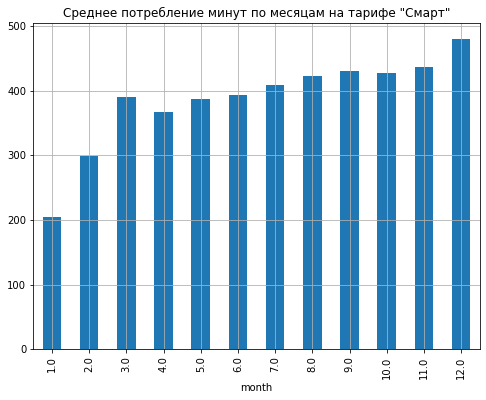

In [67]:
mean_traffs_smart = all_traffs_smart.groupby(by='month').agg('mean')

mean_traffs_smart['duration_sum'].plot(kind='bar', grid=True, figsize=(8,6), 
                                       title='Среднее потребление минут по месяцам на тарифе "Смарт"');

In [68]:
mean_traffs_smart['duration_sum'].mean()

387.203721249173

Как мы можем заметить минимальная активность по звонками на тарифе "Смарт" приходится на январь, а затем она повышется постепенно вплоть до декабря. Но даже в декабре среднее значение минут не превышает пороговое значение по тарифу - 550. Среднее значение в год составляет 387 минут в месяц.

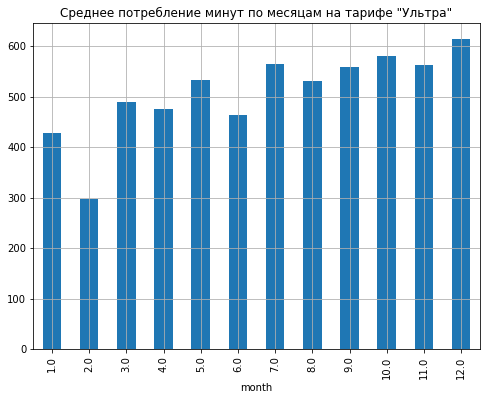

In [69]:
mean_traffs_ultra = all_traffs_ultra.groupby(by='month').agg('mean')


mean_traffs_ultra['duration_sum'].plot(kind='bar', grid=True, figsize=(8,6), 
                                       title='Среднее потребление минут по месяцам на тарифе "Ультра"');

In [70]:
mean_traffs_ultra['duration_sum'].mean()

508.37569620936756

На тарифе "Ультра" в среднем меньше всего разговаривают в феврале, но пик, также как и на тарифе "Смарт", приходится на декабрь. График выглядит хаотично, нет плавного нарастания или падения. В среднегодовое значение - 508 минут. Учитывая, что в тарифе даётся 3000 минут, средний пользователь не выговаривает и 20% от предоставленного.

Посчитаем дисперсию и стандартное отклонение и построим гистограммы плотностей вероятности.

In [71]:
variance_duration_per_month_smart = np.var(mean_traffs_smart['duration_sum'], ddof=1)
variance_duration_per_month_smart

5289.658220666891

In [72]:
standart_duration_per_month_smart = np.std(mean_traffs_smart['duration_sum'], ddof=1)
standart_duration_per_month_smart

72.730036578204

In [73]:
variance_duration_per_month_ultra = np.var(mean_traffs_ultra['duration_sum'], ddof=1)
variance_duration_per_month_ultra

7369.078532866043

In [74]:
standart_duration_per_month_ultra = np.std(mean_traffs_ultra['duration_sum'], ddof=1)
standart_duration_per_month_ultra

85.84333714893685

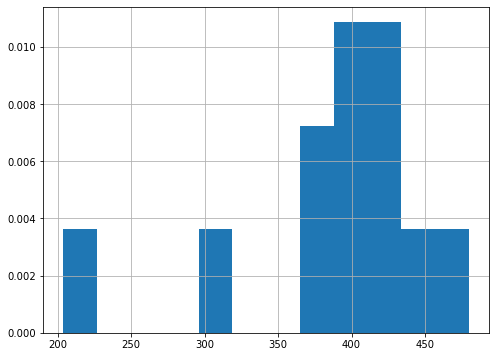

In [75]:
mean_traffs_smart['duration_sum'].hist(density=True, bins=12, grid=True, figsize=(8,6));

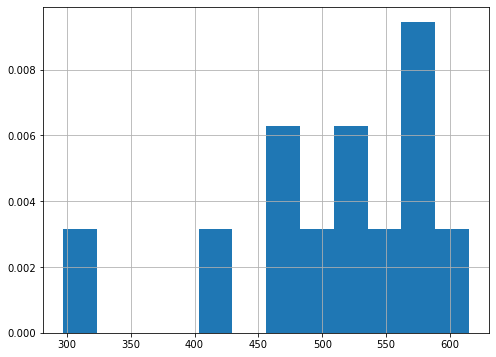

In [76]:
mean_traffs_ultra['duration_sum'].hist(density=True, bins=12, grid=True, figsize=(8,6));

Как мы видим в обоих случаях разброс дисперсии достаточно большой, а стандартное отклонение 73 и 86 соответственно. На гистограммах видно, что с большей вероятностью средний пользователь будет расходовать 400-425 минут на тарифе "Смарт" и 575 минут на тарифе "Ультра".

Посмотрим на интернет-трафик клиентов.

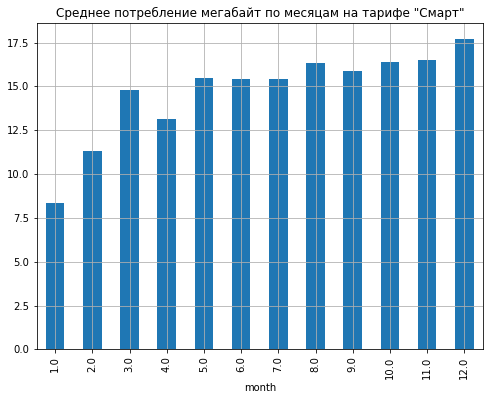

In [77]:
mean_traffs_smart['mb_used_sum'].plot(kind='bar', grid=True, figsize=(8,6), 
                                      title='Среднее потребление мегабайт по месяцам на тарифе "Смарт"');

In [78]:
mean_traffs_smart['mb_used_sum'].mean()

14.725001579178084

График распределения среднего потребления трафика по месяцам на тарифе "Смарт" схож с графиком потраченных минут. Также минимальное пользование интернетом приходится на январь, а максимальное - на декабрь. В среднем же пользователи тратят близкое к тарифному число Гигабайт.

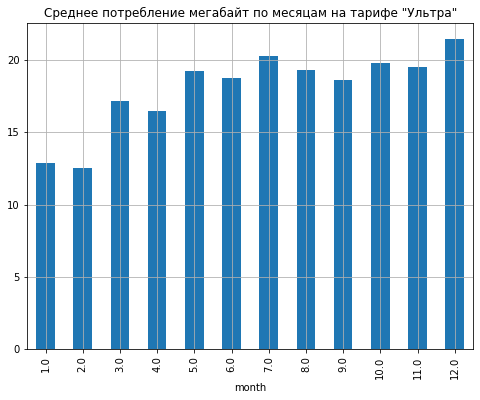

In [79]:
mean_traffs_ultra['mb_used_sum'].plot(kind='bar', grid=True, figsize=(8,6), 
                                      title='Среднее потребление мегабайт по месяцам на тарифе "Ультра"');

In [80]:
mean_traffs_ultra['mb_used_sum'].mean()

17.98383395841332

Похожая ситуация и на тарифе "Ультра". Однако среднее потребление трафика здась равно 18 Гб.

In [81]:
variance_trafic_per_month_smart = np.var(mean_traffs_smart['mb_used_sum'], ddof=1)
variance_trafic_per_month_smart

6.829210610411351

In [82]:
standart_trafic_per_month_smart = np.std(mean_traffs_smart['mb_used_sum'], ddof=1)
standart_trafic_per_month_smart

2.613275838944552

In [83]:
variance_trafic_per_month_ultra = np.var(mean_traffs_ultra['mb_used_sum'], ddof=1)
variance_trafic_per_month_ultra

7.79633639362215

In [84]:
standart_trafic_per_month_ultra = np.std(mean_traffs_ultra['mb_used_sum'], ddof=1)
standart_trafic_per_month_ultra

2.7921920409639003

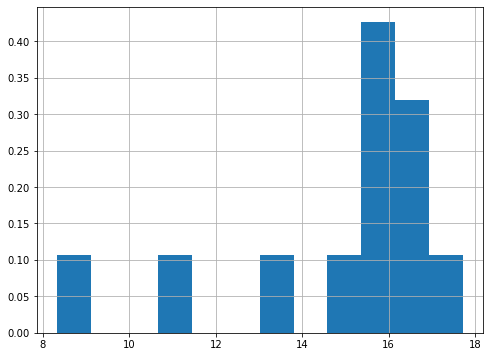

In [85]:
mean_traffs_smart['mb_used_sum'].hist(density=True, bins=12, grid=True, figsize=(8,6));

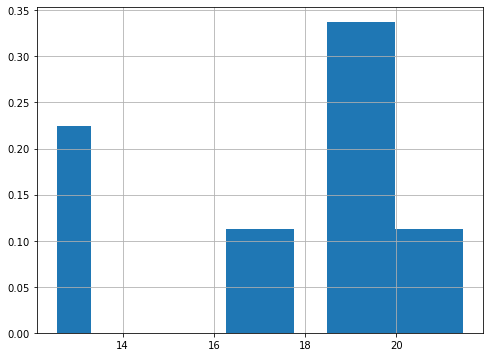

In [86]:
mean_traffs_ultra['mb_used_sum'].hist(density=True, bins=12, grid=True, figsize=(8,6));

Не смотря на то, что по тарифам пользователям предоcтавляется разное количество Гигабайт в пакете, стандартное отклонение на обоих тарифах отличается не сильно. На гистограммах вероятности распределения видно, что более 40% пользователей "Смарта" в месяц будут тратить весь пакет из предоставленных 15 Гб, а более 30 процентов будут выходить за лимит. А на тарифе "Ультра" пользователи в основном будут тратить не более 20 Гб.

Узнаем, как обстоят дела с отправкой смс в среднем на тарифах.

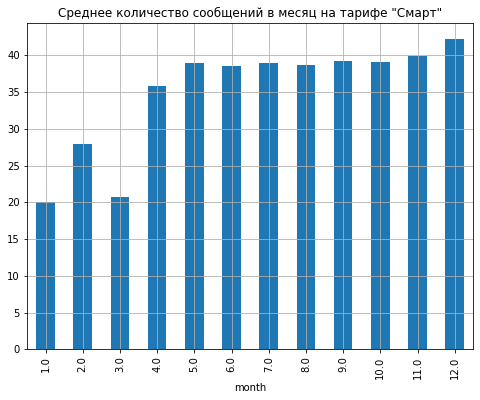

In [87]:
mean_traffs_smart['message_sum'].plot(kind='bar', grid=True, figsize=(8,6), 
                                      title='Среднее количество сообщений в месяц на тарифе "Смарт"');

In [88]:
mean_traffs_smart['message_sum'].mean()

35.03251452488063

Меньше всего сообщений на тарифе "Смарт" отправляют в январе, в среднем 20 штук, максимум же приходится на ноябрь - более 40. В среднем в месяц клиенты отправляют 36 смс-сообщений, что укладывается в тарифный пакет.

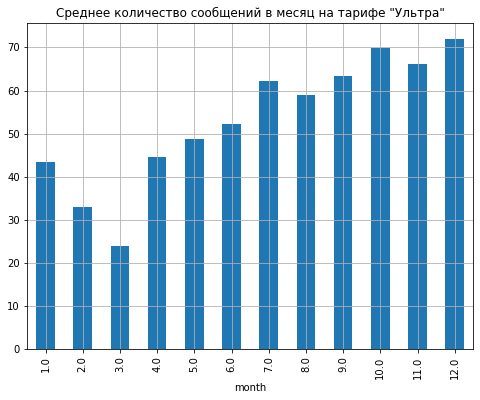

In [89]:
mean_traffs_ultra['message_sum'].plot(kind='bar', grid=True, figsize=(8,6), 
                                      title='Среднее количество сообщений в месяц на тарифе "Ультра"');

In [90]:
mean_traffs_ultra['message_sum'].mean()

53.17796200297645

График сообщений на тарифе "Ультра" похож на грфик потраченных минут. Меньше всего сообщений отправляют в феврале, в среднем более 30, максимум приходится на январь - более 70 сообщений. В среднем же на этом тарифе отправляют 54 сообщений в месяц.

In [91]:
variance_messages_per_month_smart = np.var(mean_traffs_smart['message_sum'], ddof=1)
variance_messages_per_month_smart

58.878954040836376

In [92]:
standart_messages_per_month_smart = np.std(mean_traffs_smart['message_sum'], ddof=1)
standart_messages_per_month_smart

7.6732622815094995

In [93]:
variance_messages_per_month_ultra = np.var(mean_traffs_ultra['message_sum'], ddof=1)
variance_messages_per_month_ultra

224.6498066111349

In [94]:
standart_messages_per_month_ultra = np.std(mean_traffs_ultra['message_sum'], ddof=1)
standart_messages_per_month_ultra

14.988322341447521

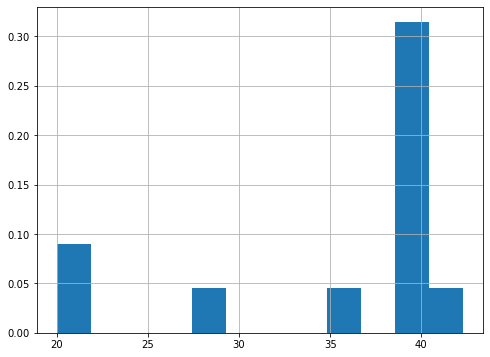

In [95]:
mean_traffs_smart['message_sum'].hist(density=True, bins=12, grid=True, figsize=(8,6));

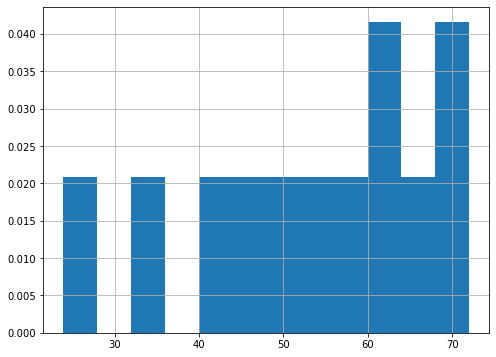

In [96]:
mean_traffs_ultra['message_sum'].hist(density=True, bins=12, grid=True, figsize=(8,6));

Дисперсия по сообщениям на тарифе "Смарт" равна 41, а на тарифе "Ультра" - 146. Стандартное отклонение отличается почти вдвое 6 и 12 соответственно. График вероятности распределения более дешёвого тарифа говорит нам о том, большей части пользователей вполне будет хватать менее 50 сообщений в месяц. А на тарифе подороже, мы видим, что клиенты могут разделиться и с равной вероятностью им одним будет хватать и 47 сообщений, а другим - 70. И это при максимуме в 1000 на тарифе. В эпоху мессенджеров сообщения не пользуются популярностью.

### Вывод
Проанализировав данные о клиентах мы можем сказать, что на обоих тарифах прослеживается определённая зависимость потребления всех видов трафика: в начале года она низкая и достигает максимума к декабрю. Также мы можем отметить, что на тарифе "Смарт" расходуют почти весь лимит минут и Гигабайт в месяц, зачастую выходя за границы этого лимита. В среднем один пользователь в месяц расходует: 387 минут, 36 сообщений и 14.7 Гб.

На тарифе "Ультра" клиенты в среднем не расходуют весь предоставленный пакет услуг и тратят чуть больше минут и Гигабайт, чем клиенты "Смарта". В среднем пользователь "Ультра" потребляет в месяц: чуть более 500 минут, 54 сообщений и 18 Гб.

Сообщения на обоих тарифах не пользуются спросом, и пользователи почти никогда не выходят за границы лимита, особенно это сложно потратить 1000 сообщений. Для клиентов выгоднее более дешёвый тариф, поскольку им вполне хватает предоставленного пакета услуг. Для «Мегалайна» же выгоднее более дорогой тариф, потому что пользователи не расходуют весь объём услуг и по сути переплачивают.

## Проверка гипотез

Исходя из уже полученных нами данных, проверим ряд гипотез. 
Для начала проверим различается ли средняя выручка пользователей обоих тарифов. На первый взгляд она различается, ведь в месяц те, у кого "Смарт", плаят по тарифу 550 рублей, а пользователи "Ультра" - 1950, что в 3,5 раза больше. Применим гипотезу о равенстве средних двух совокупностей, поскольку наши совокупности различаются тарифами.
Сформируем нулевую гипотезу H₀: средняя выручка на тарифе "Смарт" равна выручке на тарифе "Ультра". Альтернативная гипотеза H₁: средняя выручка пользователей тарифов "Смарт" и "Ультра" различается. Критический уровень статистической значимости возьмём 5%, поскольку эта вероятность является достаточной для опровержения нулевой гипотезы.

Для начала составим списки значений дохода по обоим тарифам.

In [97]:
total_income_smart_list = all_traffs_smart['total_income_smart'].values

In [98]:
total_income_ultra_list = all_traffs_ultra['total_income_ultra'].values

In [99]:
alpha = 0.05

In [100]:
sum(total_income_smart_list) / len(total_income_smart_list)

1280.2248130224373

In [101]:
sum(total_income_ultra_list) / len(total_income_ultra_list)

2068.8933200398806

Воспользуемся статистическим тестом Левене для определения дисперсий, чтобы правильно определить параметр *equal_var*.

In [102]:
stat, p = levene(total_income_smart_list, total_income_ultra_list)
p

2.0983626350416136e-123

Очень маленькое значение p говорит о том, что наши совокупности не имеют равных дисперсий.

In [103]:
results_mean_income = st.ttest_ind(total_income_smart_list, total_income_ultra_list, equal_var=False).pvalue
results_mean_income

2.4700010141005134e-259

In [104]:
if (results_mean_income < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


Полученное значение *results_mean_income* говорит нам о том, что наша нулевая гипотеза не верна. Практически со 100% вероятностью можно скзать, что средняя выручка тарифа "Смарт" не равна средней выручке тарифа "Ультра".

Теперь проверим отличается ли средняя выручка пользователей из Москвы от выручки пользователей из других регионов. Для начала подготовим данные. Выделим пользователей из Москвы и из других городов.

In [105]:
data_users_Moscow = data_users.query('city == "Москва"')
data_users_Moscow.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
7,1007,65,NaT,Москва,Юна,Березина,2018-04-19,smart
31,1031,66,NaT,Москва,Лаврентий,Тимофеев,2018-11-02,smart
33,1033,71,NaT,Москва,Лия,Бабушкина,2018-07-15,smart


In [106]:
data_users_other = data_users.query('city != "Москва"')
data_users_other.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart


Затем по *user_id* выберем в таблицах траффика по тарифам клиентов из Москвы и не из Москвы, а потом сложим эти данные, получив *total_Moscow* и *total_other*.

In [107]:
total_income_smart_Moscow = all_traffs_smart.query('user_id in @data_users_Moscow.user_id')['total_income_smart']
total_income_smart_Moscow.head()

user_id  month
1001     11.0     1350.0
         12.0      550.0
1007     4.0       550.0
         5.0      1150.0
         6.0       685.0
Name: total_income_smart, dtype: float64

In [108]:
total_income_ultra_Moscow = all_traffs_ultra.query('user_id in @data_users_Moscow.user_id')['total_income_ultra']
total_income_ultra_Moscow.head()

user_id  month
1003     8.0      1950.0
         9.0      1950.0
         10.0     1950.0
         11.0     1950.0
         12.0     1950.0
Name: total_income_ultra, dtype: float64

In [109]:
total_income_smart_other = all_traffs_smart.query('user_id in @data_users_other.user_id')['total_income_smart']
total_income_smart_other.head()

user_id  month
1002     6.0       550.0
         7.0      1150.0
         8.0      1550.0
         9.0       950.0
         10.0      550.0
Name: total_income_smart, dtype: float64

In [110]:
total_income_ultra_other = all_traffs_ultra.query('user_id in @data_users_other.user_id')['total_income_ultra']
total_income_ultra_other.head()

user_id  month
1000     5.0      1950.0
         6.0      1950.0
         7.0      1950.0
         8.0      1950.0
         9.0      1950.0
Name: total_income_ultra, dtype: float64

In [111]:
total_Moscow = total_income_smart_Moscow.append(total_income_ultra_Moscow)
total_Moscow.head()

user_id  month
1001     11.0     1350.0
         12.0      550.0
1007     4.0       550.0
         5.0      1150.0
         6.0       685.0
dtype: float64

In [112]:
total_other = total_income_smart_other.append(total_income_ultra_other)
total_other.head()

user_id  month
1002     6.0       550.0
         7.0      1150.0
         8.0      1550.0
         9.0       950.0
         10.0      550.0
dtype: float64

In [113]:
total_Moscow_list = total_Moscow.values

In [114]:
total_other_list = total_other.values

Мы получили две таблицы, две совокупности, по которым теперь можем проверить наше утверждение. 
Сформируем нулевую гипотезу H₀: средняя выручка клиентов в Москве равна средней выручке клиентов в регионах. Альтернативная гипотеза H₁: средняя выручка клиентов в Москве отличается от средней выручки в остальных городах. Критический уровень статистической значимости возьмём такой же, что и в предыдущей проверке -  5%.

In [115]:
sum(total_Moscow_list)/len(total_Moscow_list)

1537.6077170418007

In [116]:
sum(total_other_list)/len(total_other_list)

1517.957422758101

In [117]:
stat, p1 = levene(total_Moscow_list, total_other_list)
p1

0.01485856632660506

Такое значение p1 говорит о том, что наши совокупности не имеют равных дисперсий.

In [118]:
results_mean_city =  st.ttest_ind(total_Moscow_list, total_other_list, equal_var=True).pvalue
results_mean_city

0.5817876650912513

In [119]:
if (results_mean_city < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


Полученное значение *results_mean_city* говорит нам о том, что наша нулевая гипотеза верна. Мы можем сказать, доход от связи в столице и в регионах примерно равны.

# Итоговый вывод

Подводя итог нашему иcследованию мы можем сказать следующее:
* На тарифе "Смарт" люди практически полностью исчерпывают лимит пакетов минут, Гигабайт и смс, а некоторые и тратят сверх лимита, поскольку им не хватает;
* На тарифе "Ультра" люди не могут потратить за месяц положенные им лимиты на связь, порой у них остаётся много трафика по всем видам услуг в конце месяца;
* В течение года есть небольшая тенденция на постепенное увеличение потребления услуг с января по декабрь;
* Пользователи тарифов "Смарт" и "Ультра" тратят разное количество денег на связь в месяц, в среднем с одного человека с тарифом "Ультра" получают вдвое больше денег, 2016 рублей против 944 на "Смарте";
* Не смотря на различия в уровне цен в столице и регионах, клиенты компании «Мегалайн» тратят примерно одинаковое количество денег на связь.

Безусловно тариф "Ультра" финансово выгоднее для компании, и можно сконцетрироваться на его продвижении в массы и особенно заинетерсовать тех, кому не хватает пакета минут и Гигабайт на "Смарте".